# Description

This script builds and runs various General Linear Models (GLM) to identify regions in the brain that may be sensitive to ambiguity in emotion recognition. Due to computational limitations, the GLMs are run on selected Regions of Interest (ROIs) based on regions used in a prior study, excluding the Temporoparietal Junction (TPJ) as it is not defined in the Harvard-Oxford Atlas, though it can be added later using another atlas. The analysis is conducted on a part of the available dataset. Testing a linear effect for different morphing levels presents challenges, contrast vector sums should be zero, but the intervals between included conditions are unequal; high ambiguity in one emotion means high clarity in the other emotion. 

Note: 

1. Details regarding experimental design can be found on Ina's poster. 
2. The script contains many GLM models, each can take up memory. Please consider running one model at a time if your kernel dies. The different models might not be meaningful. I created some of them just for fun :) and for practicing. Please decide for yourself which are you interested in. I just leave every models in since maybe someone my want to implement something similar. 
3. Some tests are written for checking whether design matrix or mask is correct before running FirstLevelModel. These tests take up lots of memory. It's recommended to reset kernel after running them and do not run them together with FirstLevelModel (masking and desgin matrix creation is run internally in FirstLevelModel, the tests are there only for avoiding running a large model with large data with an undesirable mask or design matrix.

## Note for FDR (relevant for multiple test correction)

In Nilearn, the False Discovery Rate (FDR) threshold is calculated by ranking p-values from lowest to highest and applying a threshold formula based on the desired significance level, $\alpha$. For each p-value, a threshold is computed as:

$$
\text{threshold} = \frac{\text{rank}}{\text{number of tests}} \times \alpha
$$

Then, the largest threshold that yields significant results is applied across all voxels.

If none of the p-values meet significance (or they’re all very close to the threshold), this approach can lead to threshold values that are either very high or even undefined (infinity). For example, if we rank the lowest p-value as 1, then the threshold for that value is $\frac{1}{\text{number of tests}} \times 0.05$, often less than 0.05, making it harder for any p-values to reach significance. In cases where no p-values meet significance, Nilearn returns an infinite threshold. This effectively removes all values, even masked points with values of 0, leading them to disappear from the analysis.


## Note for FPR (relevant for multiple test correction)

In Nilearn, False Positive Rate (FPR) correction returns a z-score threshold corresponding to a specified alpha level. 

## Load packges and data

In [1]:
# We need to limit the amount of threads numpy can use, otherwise
# it tends to hog all the CPUs available when using Nilearn
import os
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

from nilearn import image, masking, plotting, datasets
from nilearn.glm.thresholding import threshold_stats_img
from nilearn.glm.first_level.design_matrix import make_first_level_design_matrix
from nilearn.glm.first_level import FirstLevelModel

from scipy.io import loadmat
import json
import numpy as np
import pandas as pd

# PATH # 
workflow_name = 'spm_preproc1'
base_path = f"/home/td/fMRI_internship/derivatives/datasink/{workflow_name}"

# SUBJECT AND TASK #
subject_list = ['sub-01', 'sub-06']
task_list = ['task-emodet']

sub = subject_list[0]
task = task_list[0]

# LOAD IMAGE #
anat = image.load_img(f"{base_path}/{sub}/{task}/wmr{sub}_T1w.nii")
# func = image.load_img(f"{base_path}/{sub}/{task}/wra{sub}_{task}_bold_roi.nii")
func = image.load_img(f"{base_path}/{sub}/{task}/fwhm-4swra{sub}_{task}_bold_roi.nii") # smooth can also be done in FirstLevelModel

# LOAD ONSETS #
onsets_file_path = os.path.join('/home/td/fMRI_internship/raw/', sub, 'func', f'{sub}_{task}_onsets.mat')
onsets_data = loadmat(onsets_file_path)

json_path = f'/home/td/fMRI_internship/raw/{sub}/func/{sub}_{task}_bold.json'
with open(json_path, 'r') as file:
    content = file.read()
    json_data = json.loads(content)
    
# LOAD OTHER NECESSARY INFO AND PARAMS:
t_r = json_data['RepetitionTime'] # get TR 
n_vols = func.shape[-1]
frame_times = np.linspace(t_r / 2, n_vols * t_r + t_r / 2, n_vols, endpoint=False) #create series of frame times
slice_time_ref = 0.25 #due to Multibandsequenz 
                        #no further slice timing within GLM is done, this is only used to define start and end time point.

### load realignment parameter to use as confounds ###
realignment_params_path = os.path.join(base_path, sub, task, f'rp_a{sub}_{task}_bold_roi.txt')
realignment_params = np.loadtxt(realignment_params_path)
realignment_params_df = pd.DataFrame(data=realignment_params, columns=["x", "y", "z", "pitch", "roll", "yaw"])
# columns 1-3 represent x, y and z translations in mm, while columns 4-6 correspond to pitch, roll and yaw rotations in radians.

## Mask Creation

In [2]:
# LOAD ATLAS:  Harvard-Oxford atlas - LABELS - uncommented since I decide to use probability atlas 
# from nilearn import regions
# from pprint import pprint

# ho_maxprob_atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')

# ho_maxprob_atlas_img = image.load_img(ho_maxprob_atlas['maps'])
# print(ho_maxprob_atlas_img.shape)

# display = plotting.plot_roi(ho_maxprob_atlas_img, colorbar=True)

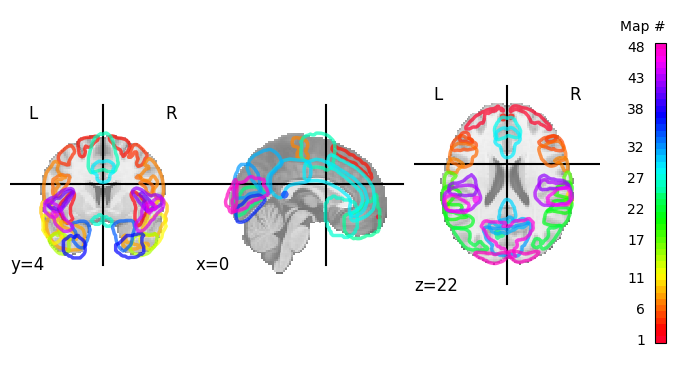

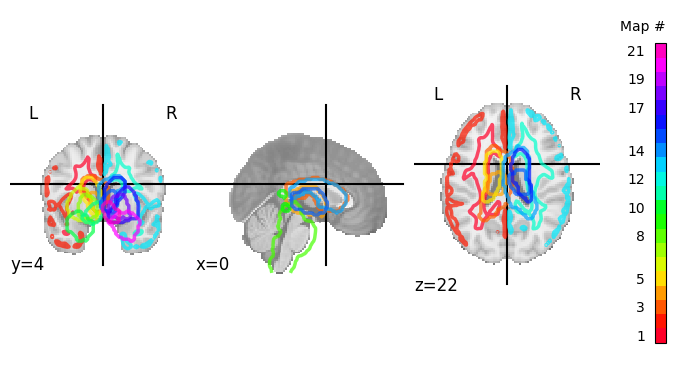

In [3]:
# LOAD ATLAS:  Harvard-Oxford atlas - PROBABILITY 
"""
There are two primary types of atlas images in FSL:

A probabilistic atlas is a 4D NIFTI image, where each 3D volume contains a probability map for one region in the atlas. 
Each 3D volum contains values between 0 and 100, indicating the probability that a given voxel is classified as belonging
to the structure represented by that volume. A label (or summary, or hard segementation) atlas is a 3D NIfTI image which 
contains different discrete integer values for each region defined in the atlas.
"""
#cortical map
ho_cort_prob_atlas = datasets.fetch_atlas_harvard_oxford('cort-prob-2mm')
ho_cort_prob_atlas_img = image.load_img(ho_cort_prob_atlas['maps'])
display = plotting.plot_prob_atlas(ho_cort_prob_atlas_img, colorbar=True)#, threshold="90%")

#sub cortical map 
ho_sub_prob_atlas = datasets.fetch_atlas_harvard_oxford('sub-prob-2mm')
ho_sub_prob_atlas_img = image.load_img(ho_sub_prob_atlas['maps'])
display = plotting.plot_prob_atlas(ho_sub_prob_atlas_img, colorbar=True)#, threshold="90%")

Creating mask for Inferior Frontal Gyrus, pars triangularis
Creating mask for Inferior Frontal Gyrus, pars opercularis
Creating mask for Insular Cortex
Creating mask for Cingulate Gyrus, anterior division
Creating mask for Cingulate Gyrus, posterior division
Creating mask for Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)
Creating mask for Frontal Medial Cortex
Creating mask for Right Amygdala
Creating mask for Left Amygdala


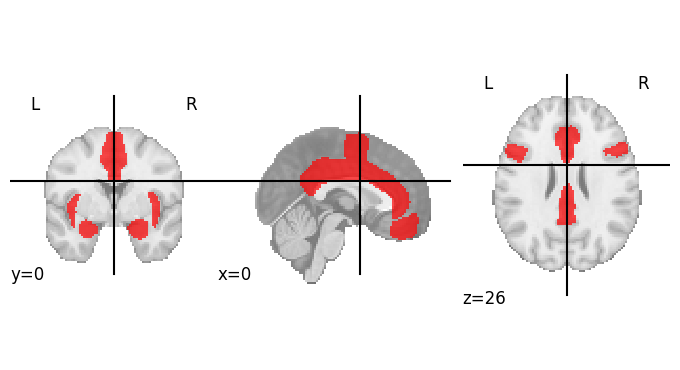

In [4]:
# CREATE MASK: 

# list all names of areas of interested (check atlas for the correct names, e.g. run: ho_cort_prob_atlas['labels'])
rois_cort_list = ["Inferior Frontal Gyrus, pars triangularis", # anterior
             "Inferior Frontal Gyrus, pars opercularis", # posterior 
             "Insular Cortex",
             "Cingulate Gyrus, anterior division",
             "Cingulate Gyrus, posterior division",
             "Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)",
                "Frontal Medial Cortex"
            ]

rois_sub_list = ['Right Amygdala', 'Left Amygdala']

# create a mask contain all those areas. For each area, one mask is created. All the maskes are eventually combined. 

show_each_mask = False # whether to plot mask of each area while creating
all_roi_masks = image.new_img_like(image.index_img(func, 0), data = np.zeros(shape=func.shape[:3])) # empty image serve for combining masks later

for rois_list, atlas in zip([rois_cort_list, rois_sub_list], [ho_cort_prob_atlas, ho_sub_prob_atlas]):

    for roi in rois_list:
        
        print(f'Creating mask for {roi}')
                
        #load mask: 
        roi_mask = image.index_img(atlas['maps'], atlas['labels'].index(roi)-1) # need to subtract 1 since background in label list but has no mask
        
        #threshold mask:
        roi_mask_thres = image.threshold_img(roi_mask, 25) #25% probability 
        
        #resample to correct for flipping and align the two voxel grids
        #world coordinates do not match to see that call func.affine and roi_mask.affine (last col on the right is world coordinate)
        roi_mask_resamp = image.resample_img(roi_mask_thres, 
                                             target_affine=func.affine, 
                                             target_shape=func.shape[:3],
                                             interpolation="nearest")

        if show_each_mask:
            display = plotting.plot_roi(roi_mask_resamp, cmap="autumn", vmin=0, title=roi)
        
        #combine mask 
        all_roi_masks = image.math_img("np.logical_or(mask1, mask2)", mask1=all_roi_masks, mask2=roi_mask_resamp)
        
plotting.plot_roi(all_roi_masks, cmap="autumn")

In [ ]:
# apply mask #only for TESTING whether the mask created before works
# this step can be skip since the FirstLevelModel can take the mask and apply it internally. 

masked_func_2D = masking.apply_mask(func, all_roi_masks)
masked_func = masking.unmask(masked_func_2D, all_roi_masks)

plotting.view_img(image.index_img(masked_func, 100))

## First level model - GLM

In [5]:
hrf_model = "glover"
drift_model = "cosine" # account for scanner drift
high_pass = 0.01 # frenquently use, filter out slow components
noise_model = "ar1" #modeling temporal autocorrelation
minimize_memory = False
n_jobs = 2 #how many CPU cores the GLM analysis will use

flm = FirstLevelModel(
    t_r=t_r,
    slice_time_ref=slice_time_ref,
    hrf_model=hrf_model,
    drift_model=drift_model,
    high_pass=high_pass,
    noise_model=noise_model,
    n_jobs=n_jobs,
    mask_img=all_roi_masks,
    minimize_memory=minimize_memory,
    verbose=True  # this will print out some useful info later
)

## Run Model Option 1 - Modulation integrated in the same regressor as emotion

Problem in this approach is the way ambiguitiy is quanitified, e.g. morph_20_80 for angry fearful can be considered high ambiguity for angry but low ambiguity for fearful

In [ ]:
# create events_df, containing info about trial type, its onset and modulation if given

events_df = pd.DataFrame(columns=['onset', 'duration', 'trial_type', 'modulation'])

onset = []
modulation = [] # ambiguity level of emotion
modulation_ori = []

# loop through all condition, use start time of each condition to sort the onset in different condition.

# determine morph level:
for i, name in enumerate(n[0] for n in onsets_data['names'][0] if "morph" in n[0]):
    current_onset = onsets_data['onsets'][0][i].squeeze()
    onset.extend(current_onset)
    
    # quantify morph level 
    modulation_factor = int(name.split("_")[1])/int(name.split("_")[2])
    modulation_factor = int(name.split("_")[1])/100
    modulation.extend([modulation_factor]*len(current_onset))
    
    modulation_ori.extend([name]*len(current_onset))

events_df['modulation_ori']=modulation_ori
events_df['onset']=onset
events_df['modulation']=modulation
events_df['modulation']-=events_df['modulation'].mean()
events_df['duration']=1

# determine emotion of stimuli in each trial 
bins = sorted([o[0][0] for o in onsets_data['onsets'][0][5:]])
labels = [n[0] for n in onsets_data['names'][0] if "morph" not in n[0]]
bins.append(max(events_df['onset'])+0.01)

events_df['trial_type'] = pd.cut(events_df['onset'], bins=bins, labels=labels, right=False)
events_df['trial_type'] = events_df['trial_type'].astype(str)
events_df = events_df.sort_values(by="onset", ascending=True).reset_index(drop=True)

In [ ]:
# CREATE DESIGN MATRIX - only for TESTING events_df 
# FirstLevelModel can call make_first_level_design_matrix internally so this step can be skipped.

dm = make_first_level_design_matrix(frame_times=frame_times,
                                   events = events_df,
                                   hrf_model = 'glover',
                                   drift_model= 'cosine', 
                                   high_pass = 0.01)

plotting.plot_design_matrix(dm.iloc[:, :6])

In [ ]:
# RUN MODEL - run for all voxels cannot be done due to limited computer power - only run for two categories of emotion
events_angry = events_df[events_df['trial_type'].isin(["angry-fearful", "angry-happy"])]

# largest onset of events_angry is 717.287, divided by t_r give 553.5 therefore take the first 555 voxels for analysis 
flm.fit(run_imgs=image.index_img(func, np.arange(0, 555)),
        events=events_angry, 
        confounds=realignment_params_df[:555])

In [ ]:
# check and plot the design matrix created by FirstLevelModel
flm_dm = flm.design_matrices_[0]
plotting.plot_design_matrix(flm_dm)

In [ ]:
r2_img = flm.r_square[0] # variance explained by predictors 
plotting.plot_stat_map(r2_img, threshold=0.2, cmap="autumn")

In [ ]:
resids = flm.residuals[0] # screen residuals 
print(resids.shape)
plotting.plot_roi(image.index_img(resids, 100), cmap="autumn", colorbar=True)

In [ ]:
# CONTRAST CALCULATION

In [ ]:
# emo against each other 
con_emo_vect = np.zeros(flm_dm.shape[1]) # set multiplication factor as 0 for all regressor 
con_emo_vect[0] = 1 # set multiplication factor for regressors you are interested in 
con_emo_vect[1] = -1 # set multiplication factor for regressors you are interested in

con_emo = flm.compute_contrast(con_emo_vect, stat_type="t", output_type="z_score")

display = plotting.plot_stat_map(con_emo, cmap="autumn", threshold=1.96) #0.05

# please refer to note for fdr and fpr at the beginning
con_emo_thres, used_threshold = threshold_stats_img(con_emo, height_control='fdr', alpha=0.05, cluster_threshold=10)
display = plotting.plot_stat_map(con_emo_thres, cmap="autumn")

In [ ]:
# emo against baseline
# please refer to note for fdr and fpr at the beginning

con_angry_fearful = flm.compute_contrast("angry-fearful", stat_type="t", output_type="z_score")
# display = plotting.plot_stat_map(con_angry_fearful, cmap="autumn", threshold=1.96)

con_angry_fearful_thres, used_threshold = threshold_stats_img(con_angry_fearful, height_control='fdr', alpha=0.05, cluster_threshold=10)
display = plotting.plot_stat_map(con_angry_fearful_thres, cmap="autumn")

#---------------------------------------------------------------------------------------------

con_angry_happy = flm.compute_contrast("angry-happy", stat_type="t", output_type="z_score")
# display = plotting.plot_stat_map(con_angry_happy, cmap="autumn", threshold=1.96)

con_angry_happy_thres, used_threshold = threshold_stats_img(con_angry_happy, height_control='fdr', alpha=0.05, cluster_threshold=10)
display = plotting.plot_stat_map(con_angry_happy_thres, cmap="autumn")

#---------------------------------------------------------------------------------------------
# you can save the file to inspect in other program like SPM or FSL if they are meaningful and maybe if you want to load atlas under them to define regions
# con_angry_fearful_thres.to_filename(f"/home/td/fMRI_internship/derivatives-ni-edu-env/{sub}/{task}/glm_af-baseline_no-modulation.nii")
# con_angry_happy_thres.to_filename(f"/home/td/fMRI_internship/derivatives-ni-edu-env/{sub}/{task}/glm_ah-baseline_no-modulation.nii")

## Run Model Option 2 - all morph level integrated in a separate regressor 

In [ ]:
# create events_df to determina trial types and their onset, modulation if given. 
events_df = pd.DataFrame(columns=['onset', 'duration', 'trial_type', 'modulation'])

onset = []
modulation = [] # ambiguity level of emotion
modulation_ori = []

# determine morph level as modulation 
for i, name in enumerate(n[0] for n in onsets_data['names'][0] if "morph" in n[0]):
    current_onset = onsets_data['onsets'][0][i].squeeze()
    onset.extend(current_onset)
    
    modulation_factor = int(name.split("_")[1])/int(name.split("_")[2])
    modulation_factor = int(name.split("_")[1])/100
    modulation.extend([modulation_factor]*len(current_onset))
    
    modulation_ori.extend([name]*len(current_onset))

# events_df['modulation_ori']=modulation_ori
events_df['onset']=onset
events_df['modulation']=modulation
events_df['modulation']-=events_df['modulation'].mean()
events_df['duration']=1

# determine trial type
bins = sorted([o[0][0] for o in onsets_data['onsets'][0][5:]])
labels = [n[0] for n in onsets_data['names'][0] if "morph" not in n[0]]
bins.append(max(events_df['onset'])+0.01)

events_df['trial_type'] = pd.cut(events_df['onset'], bins=bins, labels=labels, right=False)
events_df['trial_type'] = events_df['trial_type'].astype(str)
events_df = events_df.sort_values(by="onset", ascending=True).reset_index(drop=True)

In [ ]:
# create design matrix - cannot be skipped, this is NOT a test.
# FirstLevelModel can also take design matrix directly and run the model (rather than take events_df and create design matrix internally)
# I choose this approach since I want to create a seperate regressor only for morph level

### create regressor for morph level with modulation 
events_one_mol = events_df.copy() #already contain modulation factor, only need to change all trial_type to morph
events_one_mol['trial_type']="morph"

dm_mol = make_first_level_design_matrix(frame_times = frame_times, 
                                        events = events_one_mol,
                                        hrf_model = 'glover',
                                        drift_model= 'cosine',
                                        high_pass = 0.01)

reg_mol = dm_mol.iloc[:, 0].to_numpy()[:, np.newaxis]
reg_mol_names = list("modulator_"+events_one_mol['trial_type'].unique())

### combine morph regressor with other regressor (for emotion and realignment parameters and drifts)
dm = make_first_level_design_matrix(frame_times=frame_times,
                                   events = events_df.iloc[:, :3],
                                   hrf_model = 'glover',
                                   drift_model = 'cosine',
                                   high_pass = 0.01,
                                   add_regs = np.hstack((reg_mol, realignment_params)),
                                   add_reg_names = reg_mol_names+list(realignment_params_df.columns.values))

plotting.plot_design_matrix(dm.iloc[:, :7])
plotting.plot_design_matrix(dm)

In [ ]:
# due to limitation of computer power, run model only for some trial type
events_angry = events_df[events_df['trial_type'].isin(["angry-fearful", "angry-happy"])]

# largest onset of events_angry is 717.287, divided by t_r give 553.5 therefore take the first 555 voxels for analysis 
flm.fit(run_imgs=image.index_img(func, np.arange(0, 555)),
       design_matrices=dm.iloc[:555, :])

In [ ]:
r2_img = flm.r_square[0] # variance explained by predictors 
plotting.plot_stat_map(r2_img, threshold=0.2, cmap="autumn")

In [ ]:
# CONTRAST CALCULATION

In [ ]:
# check design matrix
flm_dm = flm.design_matrices_[0]
plotting.plot_design_matrix(flm_dm)

In [ ]:
# emo against baseline

con_angry_fearful = flm.compute_contrast("angry-fearful", stat_type="t", output_type="z_score")
display = plotting.plot_stat_map(con_angry_fearful, cmap="autumn", threshold=1.96)

con_angry_fearful_thres, used_threshold = threshold_stats_img(con_angry_fearful, height_control="fdr", alpha=0.05, cluster_threshold=10)
display = plotting.plot_stat_map(con_angry_fearful_thres, cmap="autumn")

#---------------------------------------------------------------------------------------------

con_angry_happy = flm.compute_contrast("angry-happy", stat_type="t", output_type="z_score")
display = plotting.plot_stat_map(con_angry_happy, cmap="autumn", threshold=1.96)

con_angry_happy_thres, used_threshold = threshold_stats_img(con_angry_happy, height_control="fdr", alpha=0.05, cluster_threshold=10)
display = plotting.plot_stat_map(con_angry_happy_thres, cmap="autumn")

#---------------------------------------------------------------------------------------------
# save file if needed to open in other programs, etc. 
# con_angry_fearful_thres.to_filename(f"/home/td/fMRI_internship/derivatives-ni-edu-env/{sub}/{task}/glm_af-baseline_w-modulation.nii")
# con_angry_happy_thres.to_filename(f"/home/td/fMRI_internship/derivatives-ni-edu-env/{sub}/{task}/glm_ah-baseline_w-modulation.nii")

# for one modulator regressor
con_modul = flm.compute_contrast('modulator_morph', stat_type="t", output_type="z_score")
display = plotting.plot_stat_map(con_modul, cmap="autumn", threshold=1.96)

con_modul_thres, used_threshold = threshold_stats_img(con_modul, height_control="fpr", alpha=0.05)
display = plotting.plot_stat_map(con_modul_thres, cmap="autumn")

## Run Model Option 3 -  Morph Level as Regressor (no differentiation between emotion categories)

In [6]:
# create events_df to determina trial types and their onset, modulation if given. 
events_df = pd.DataFrame(columns=['onset', 'duration', 'trial_type'])

onset = []
trial_type = []

for i, name in enumerate(n[0] for n in onsets_data['names'][0] if "morph" in n[0]):
    current_onset = onsets_data['onsets'][0][i].squeeze()
    onset.extend(current_onset)
    trial_type.extend([name]*len(current_onset))

events_df['onset']=onset
events_df['duration']=1
events_df['trial_type']=trial_type
events_df

events_df = events_df.sort_values(by="onset", ascending=True).reset_index(drop=True)

In [7]:
# due to limited computer power, run only for half of the experiment, morph level is balanced in the first half. 
cut = 240 #480 trials in total for the original dataset 
cut_func = round(func.shape[-1]/2)
    
flm.fit(run_imgs=image.index_img(func, np.arange(0, cut_func)),
        events=events_df.iloc[:cut, :], 
        confounds=realignment_params_df.iloc[:cut_func, :])

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 22.988778114318848 seconds.



FirstLevelModel(mask_img=<nibabel.nifti1.Nifti1Image object at 0x7eff2aaa6250>,
                minimize_memory=False, n_jobs=2, slice_time_ref=0.25, t_r=1.296,
                verbose=True)

morph_20_80
2.301604227469397
morph_40_60
2.320810546367539
morph_50_50
2.3451632859309877
morph_45_55
2.2714916668954324
morph_0_100
2.2990884177797604


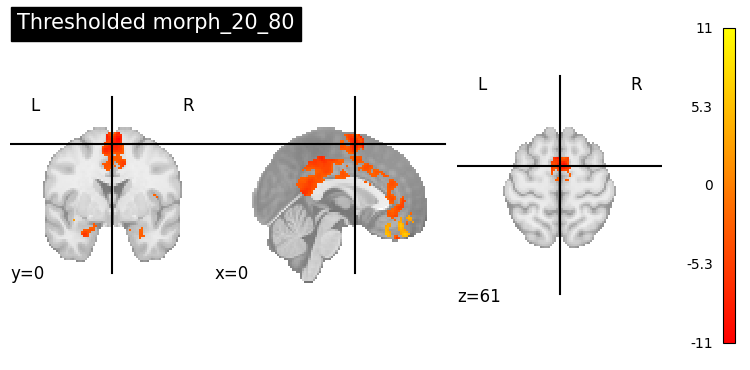

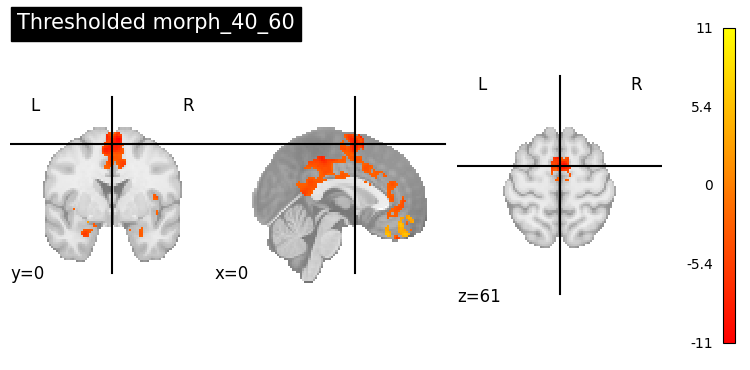

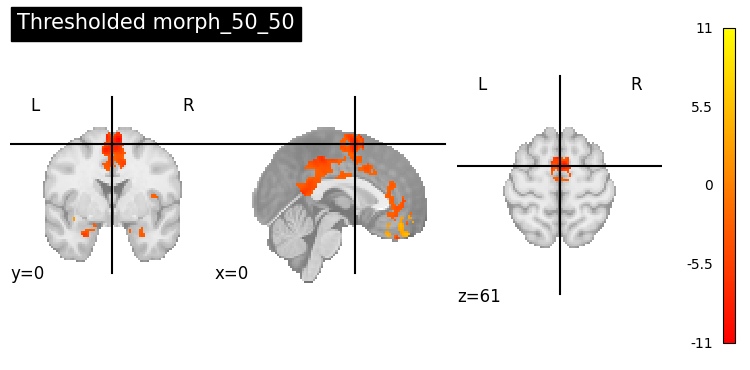

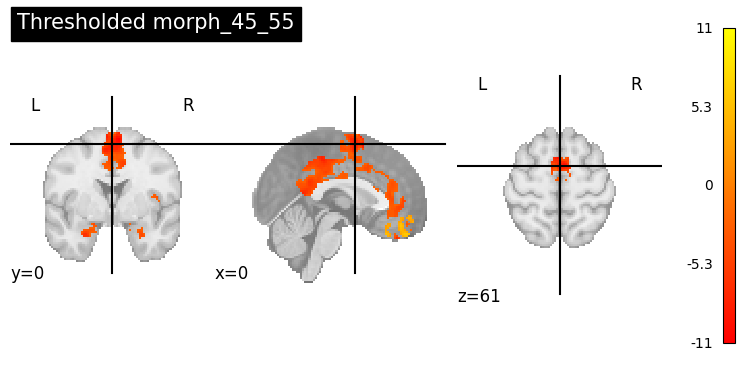

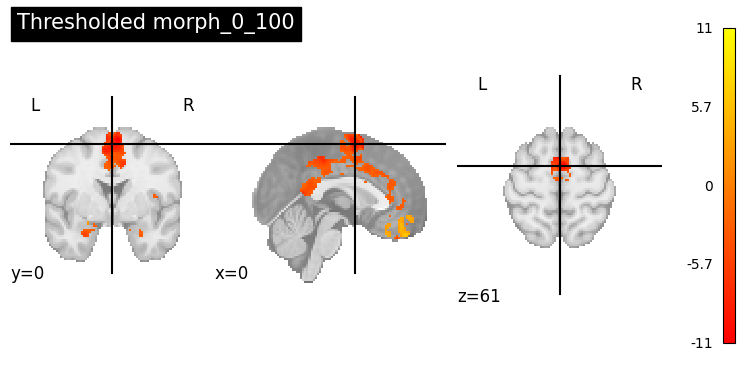

In [8]:
# contrast - each morph level against baseline 
for type in events_df['trial_type'].unique():
    print(type)
    contrast = flm.compute_contrast(type, stat_type="t", output_type="z_score")
#     display = plotting.plot_stat_map(contrast, cmap="autumn", title=type)

    contrast_thres, used_threshold = threshold_stats_img(contrast, height_control="fdr", alpha=0.05, mask_img=all_roi_masks)
    print(used_threshold)
    
    display = plotting.plot_stat_map(contrast_thres, cmap="autumn", title=f'Thresholded {type}', cut_coords=(0,0,61))

# plotting.view_img(contrast_thres, cmap="autumn")

<Axes: label='conditions', ylabel='scan number'>

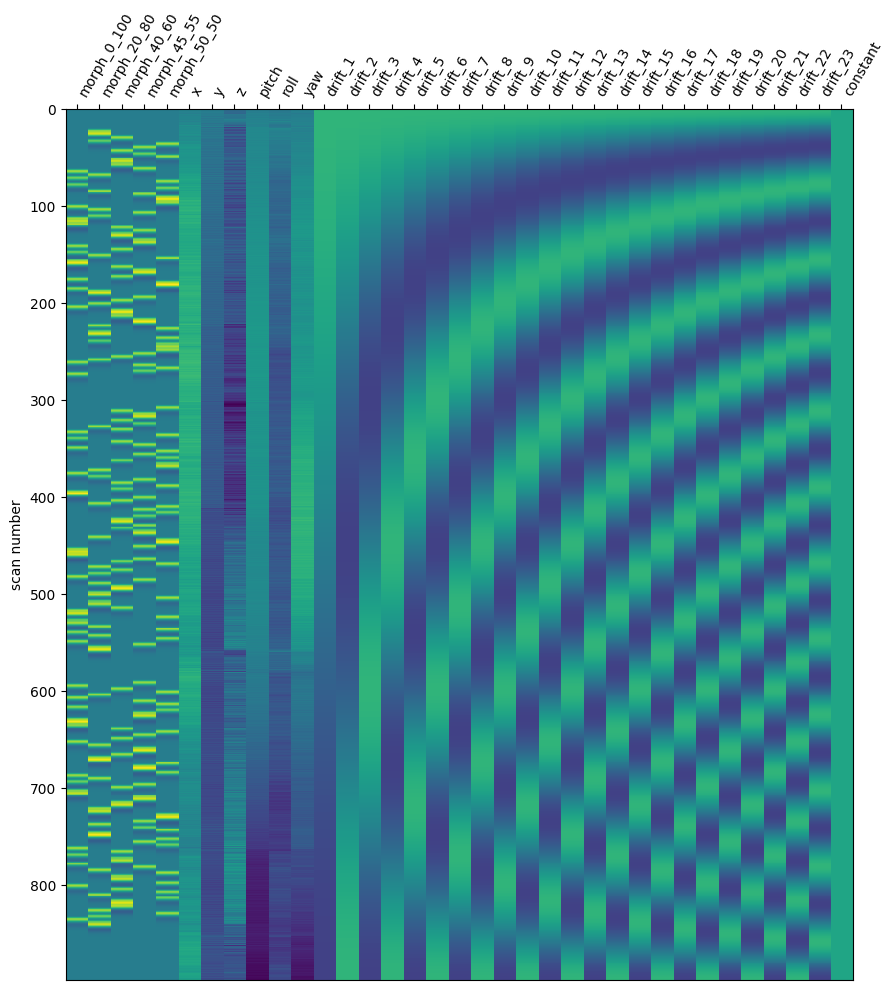

In [9]:
# check design matrix 
flm_dm = flm.design_matrices_[0]
plotting.plot_design_matrix(flm_dm)

/home/td/miniconda3/envs/ni-edu/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



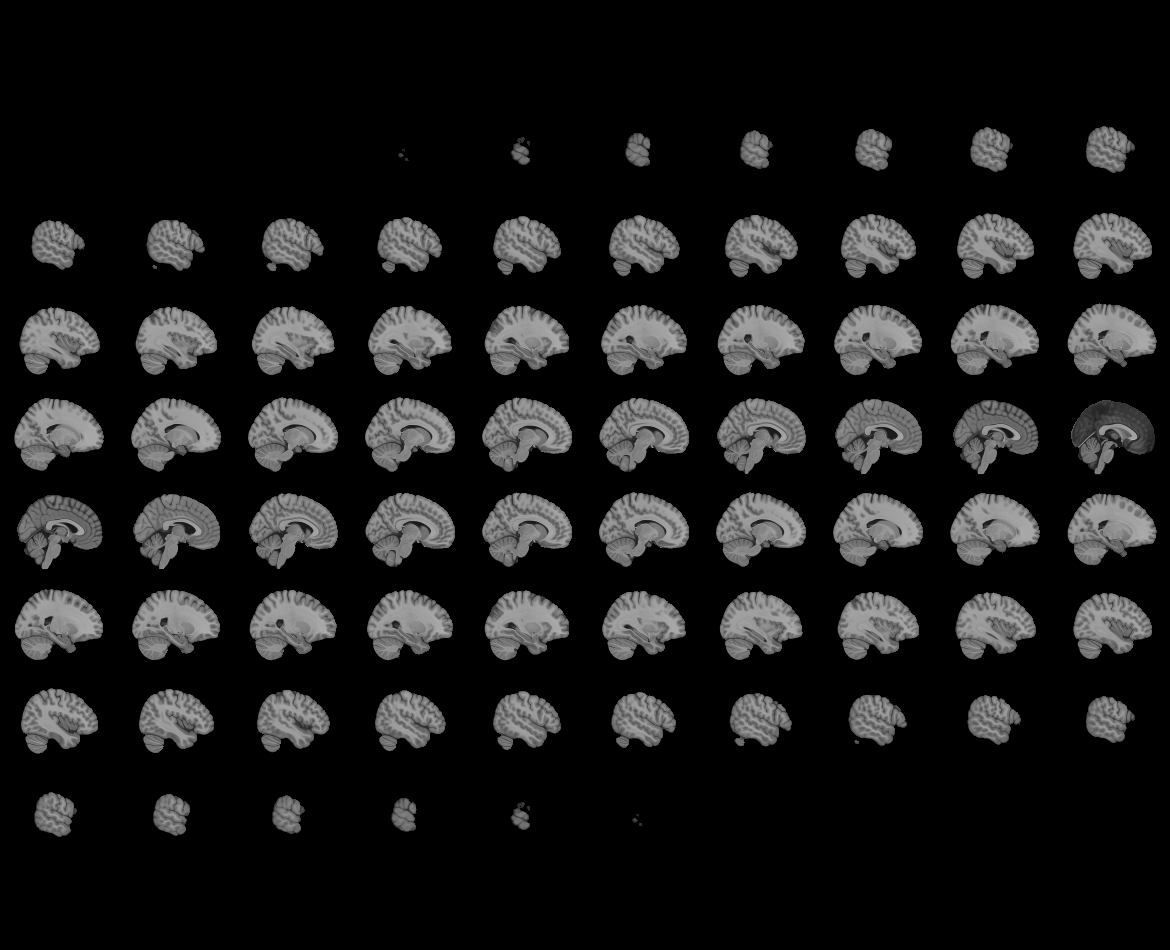
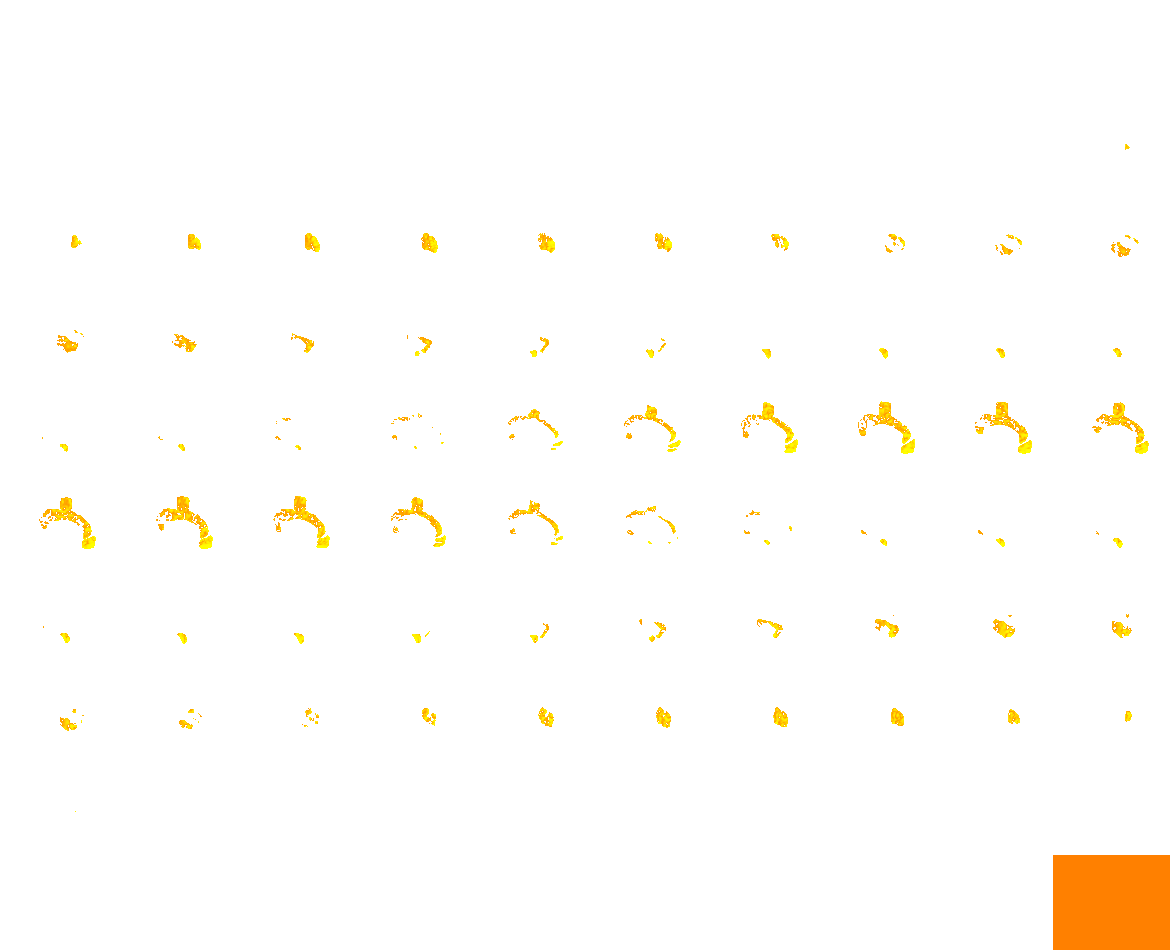

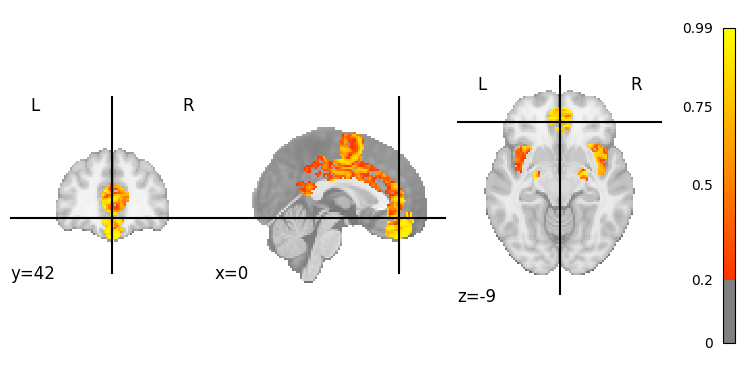

In [10]:
r2_img = flm.r_square[0] # variance explained by predictors 
plotting.plot_stat_map(r2_img, threshold=0.2, cmap="autumn")
plotting.view_img(r2_img, cmap='autumn', threshold=0.2)

3.4679537180423092


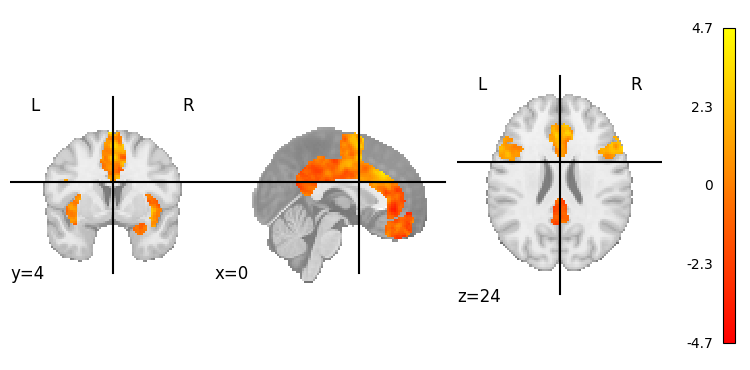

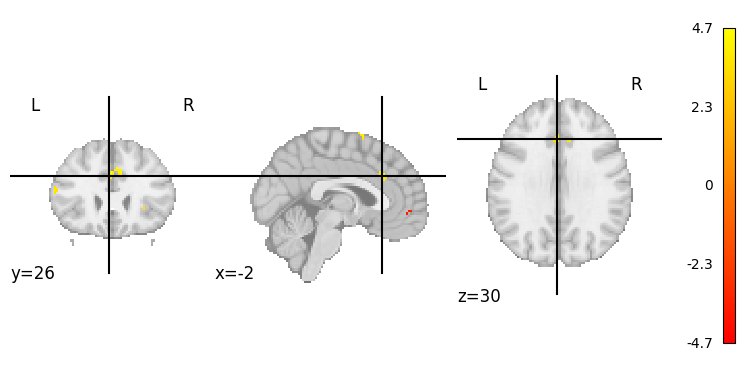

In [11]:
# contrast - ambiguity - problematic as mentioned in description 
c_vect_morph =  np.array(sorted(np.array([float(amb.split("_")[1])/100 for amb in events_df['trial_type'].unique()])))
c_vect_morph-= c_vect_morph.mean()

c_vect = np.zeros(flm_dm.shape[1])
c_vect[0:5] = c_vect_morph

contrast = flm.compute_contrast(c_vect, stat_type="t", output_type="z_score")
display = plotting.plot_stat_map(contrast, cmap="autumn")

contrast_thres, used_threshold = threshold_stats_img(contrast, height_control="fdr", alpha=0.05, mask_img=all_roi_masks)
print(used_threshold)
display = plotting.plot_stat_map(contrast_thres, cmap="autumn")

4.132270482064229


/home/td/miniconda3/envs/ni-edu/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



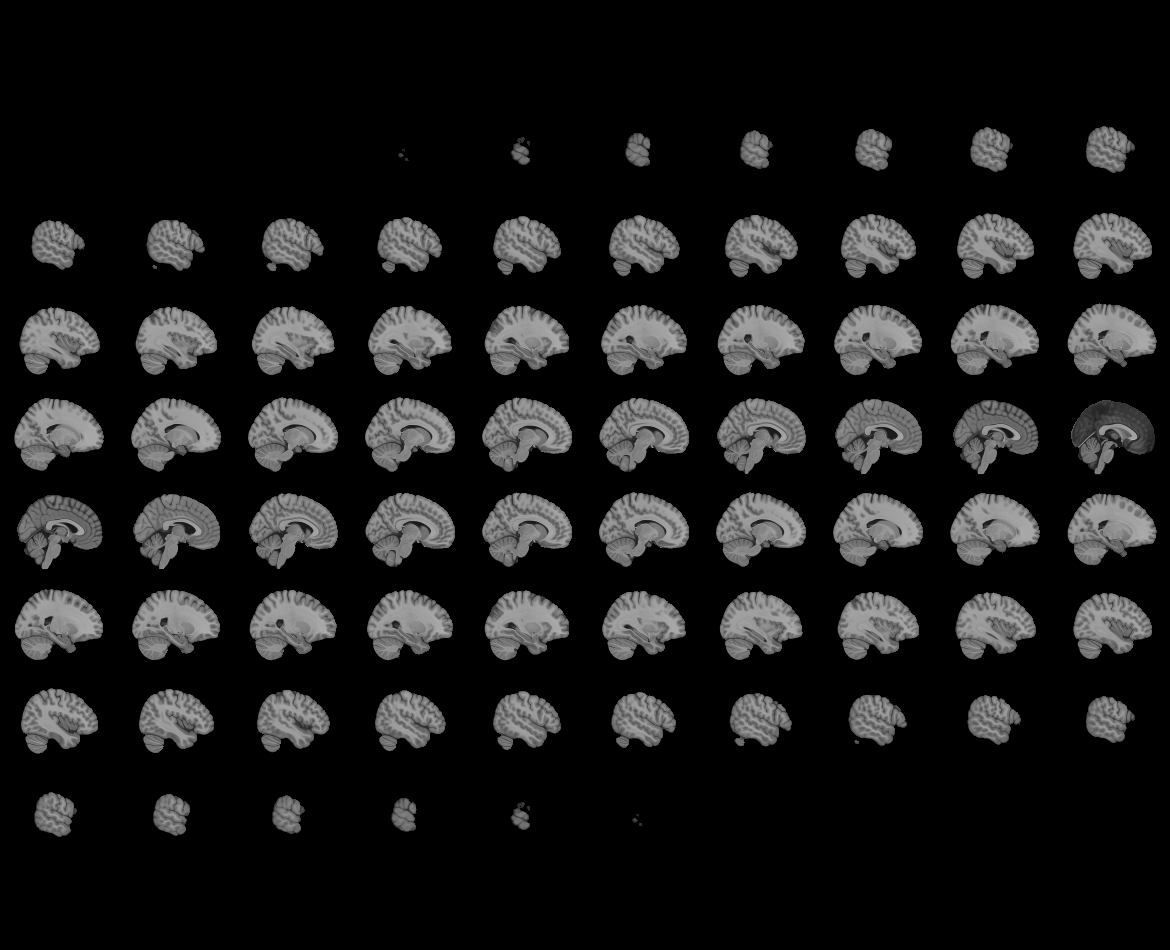
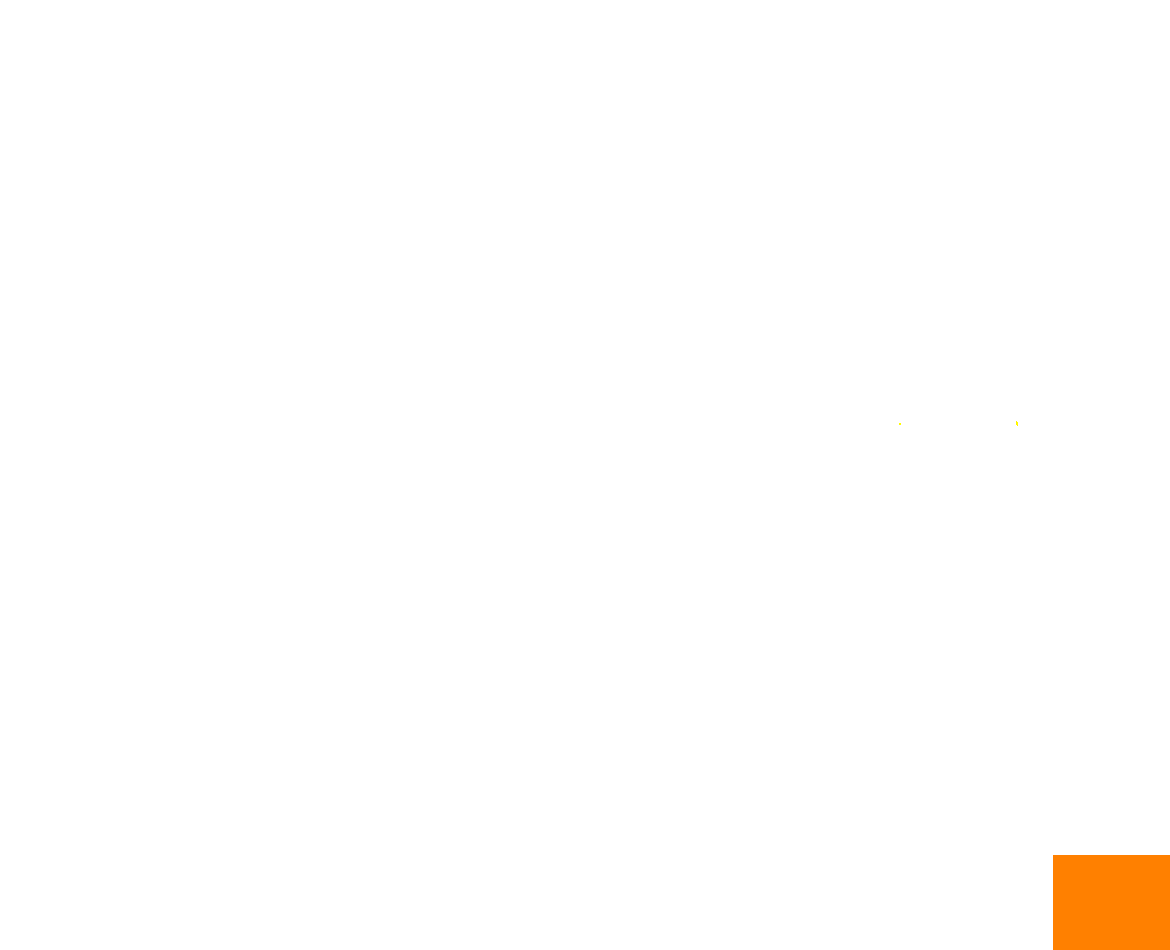

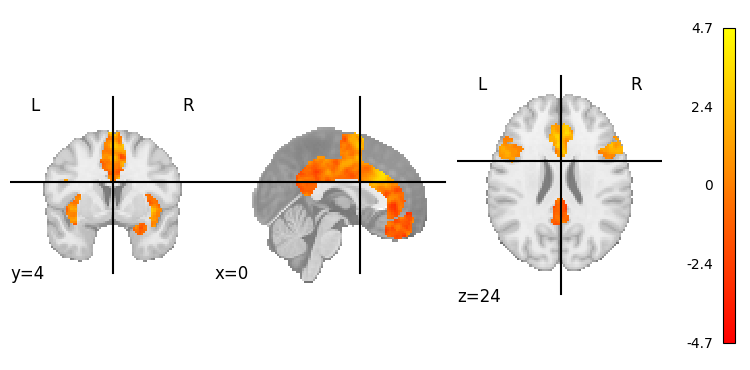

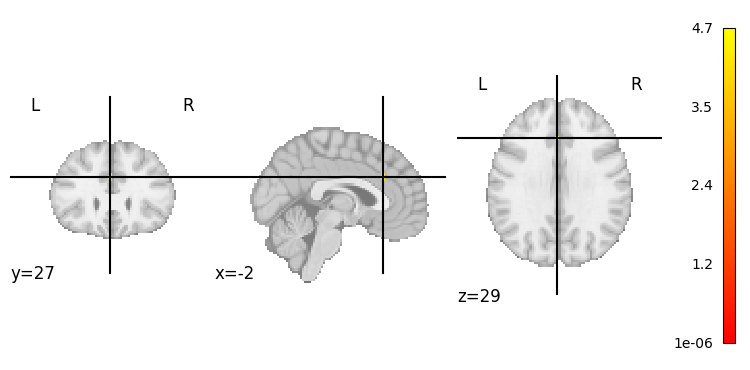

In [12]:
# contrast - certainty - problematic as mentioned in description
c_vect_morph =  np.array(sorted(np.array([int(amb.split("_")[2])/100 for amb in events_df['trial_type'].unique()])))
c_vect_morph-= c_vect_morph.mean()

c_vect = np.zeros(flm_dm.shape[1])
c_vect[0:5] = c_vect_morph


contrast = flm.compute_contrast(c_vect, stat_type="t", output_type="z_score")
display = plotting.plot_stat_map(contrast, cmap="autumn")

contrast_thres, used_threshold = threshold_stats_img(contrast, height_control="fdr", alpha=0.05, mask_img=all_roi_masks)
print(used_threshold)
display = plotting.plot_stat_map(contrast_thres, cmap="autumn")

plotting.view_img(contrast_thres, threshold=1.96, cmap="autumn")

/home/td/miniconda3/envs/ni-edu/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



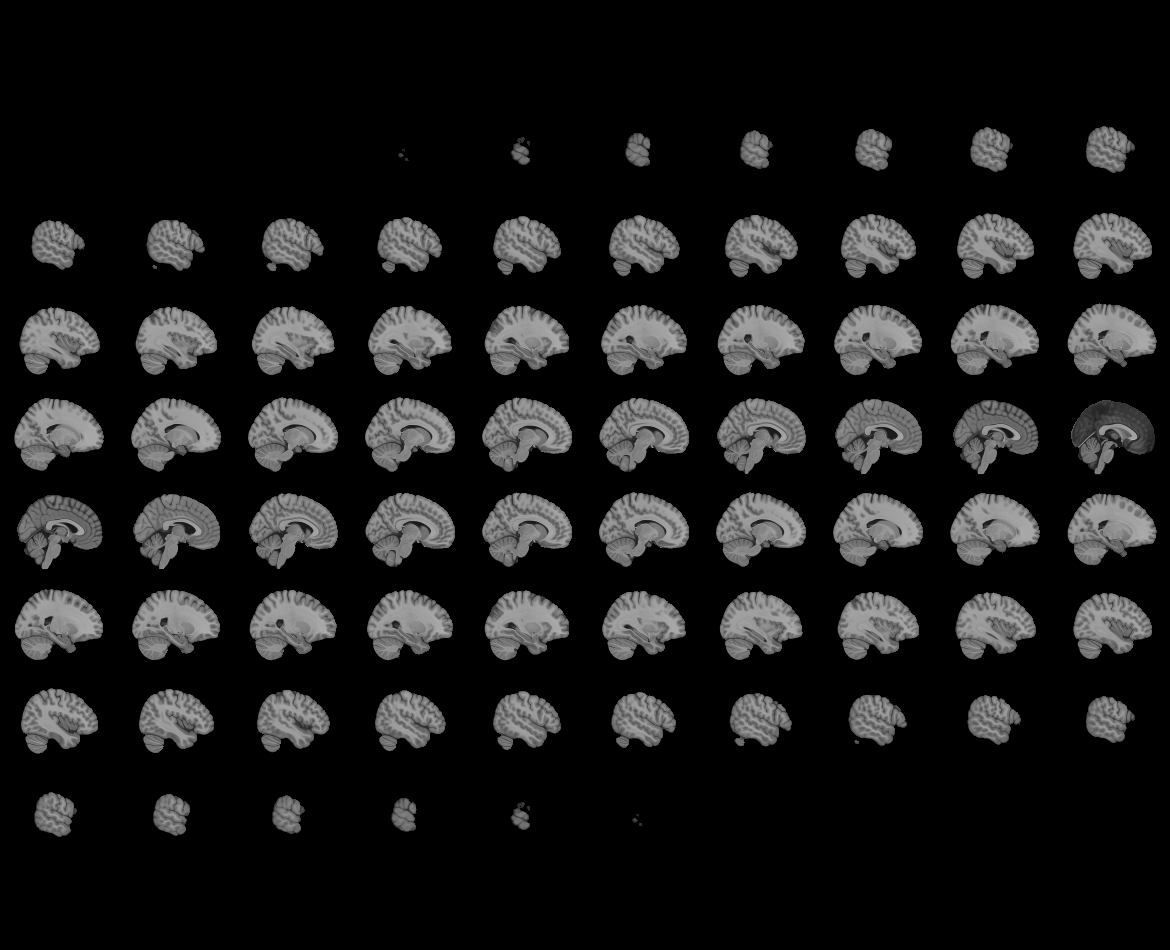
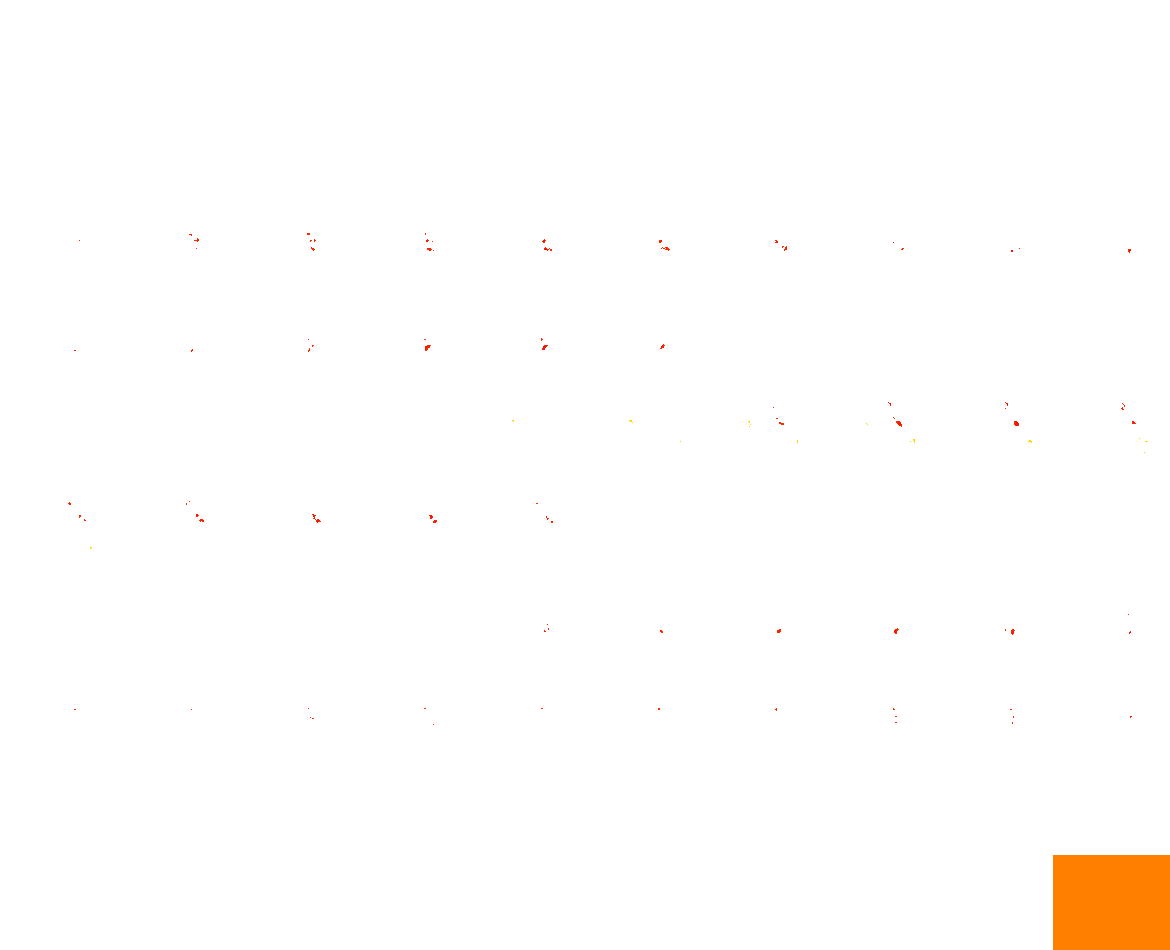

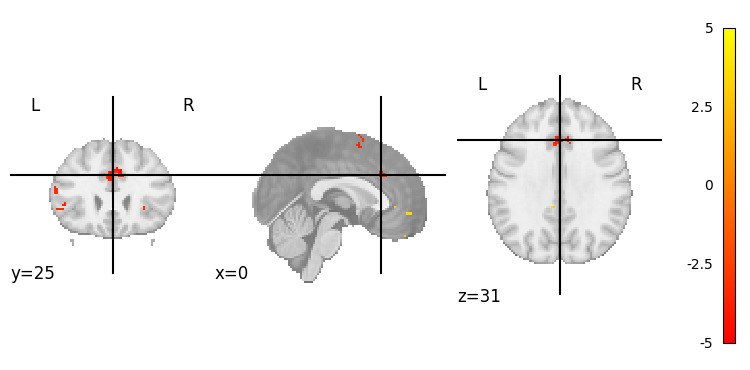

In [13]:
# contrast 0_100 50_50

c_vect = np.zeros(flm_dm.shape[1])
c_vect[0] = 1 # morph_0_100
c_vect[4] = -1 # morph_50_50

contrast = flm.compute_contrast(c_vect, stat_type="t", output_type="z_score")
# display = plotting.plot_stat_map(contrast, cmap="autumn")

contrast_thres, used_threshold = threshold_stats_img(contrast, height_control="fdr", alpha=0.05, mask_img=all_roi_masks)
# print(used_threshold)
display = plotting.plot_stat_map(contrast_thres, cmap="autumn")

plotting.view_img(contrast_thres, cmap="autumn")

2.3416488765251042


/home/td/miniconda3/envs/ni-edu/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



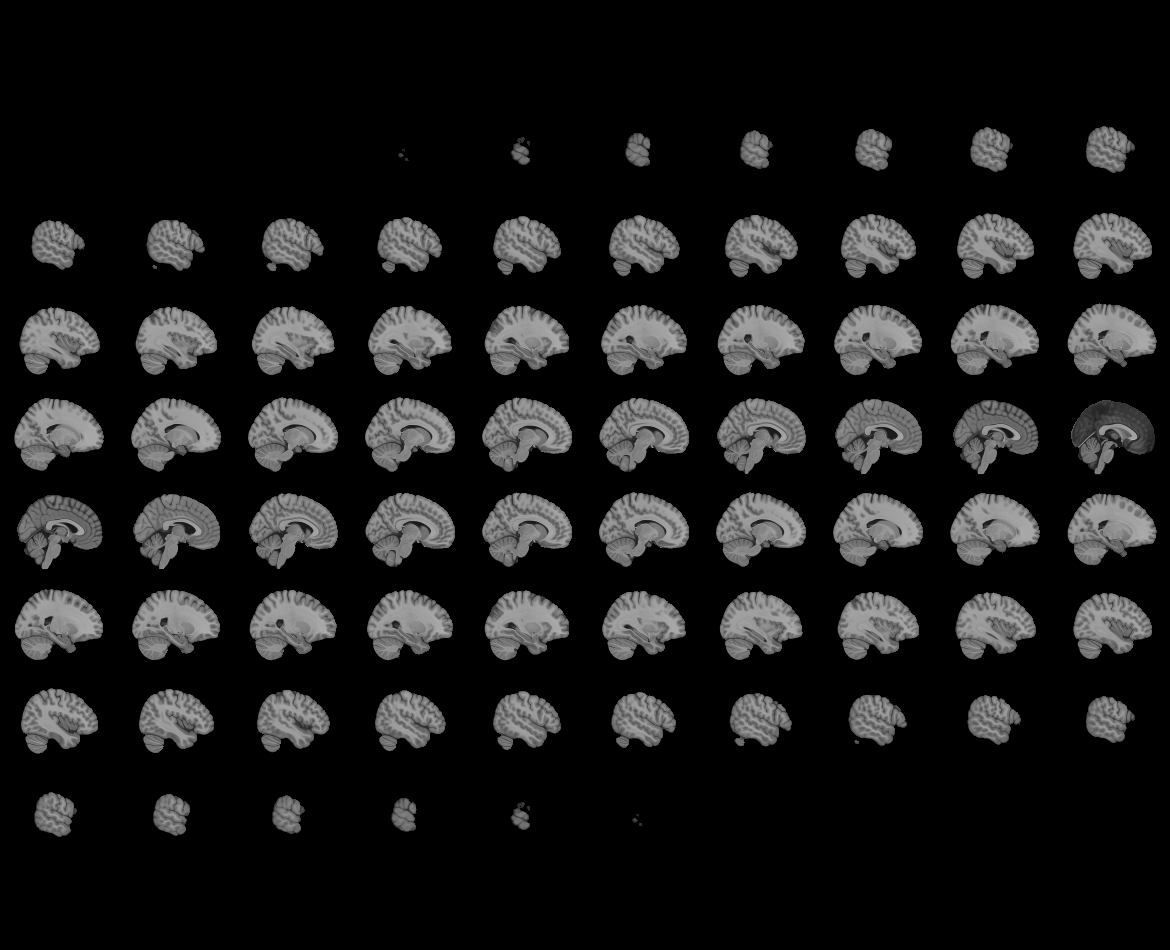
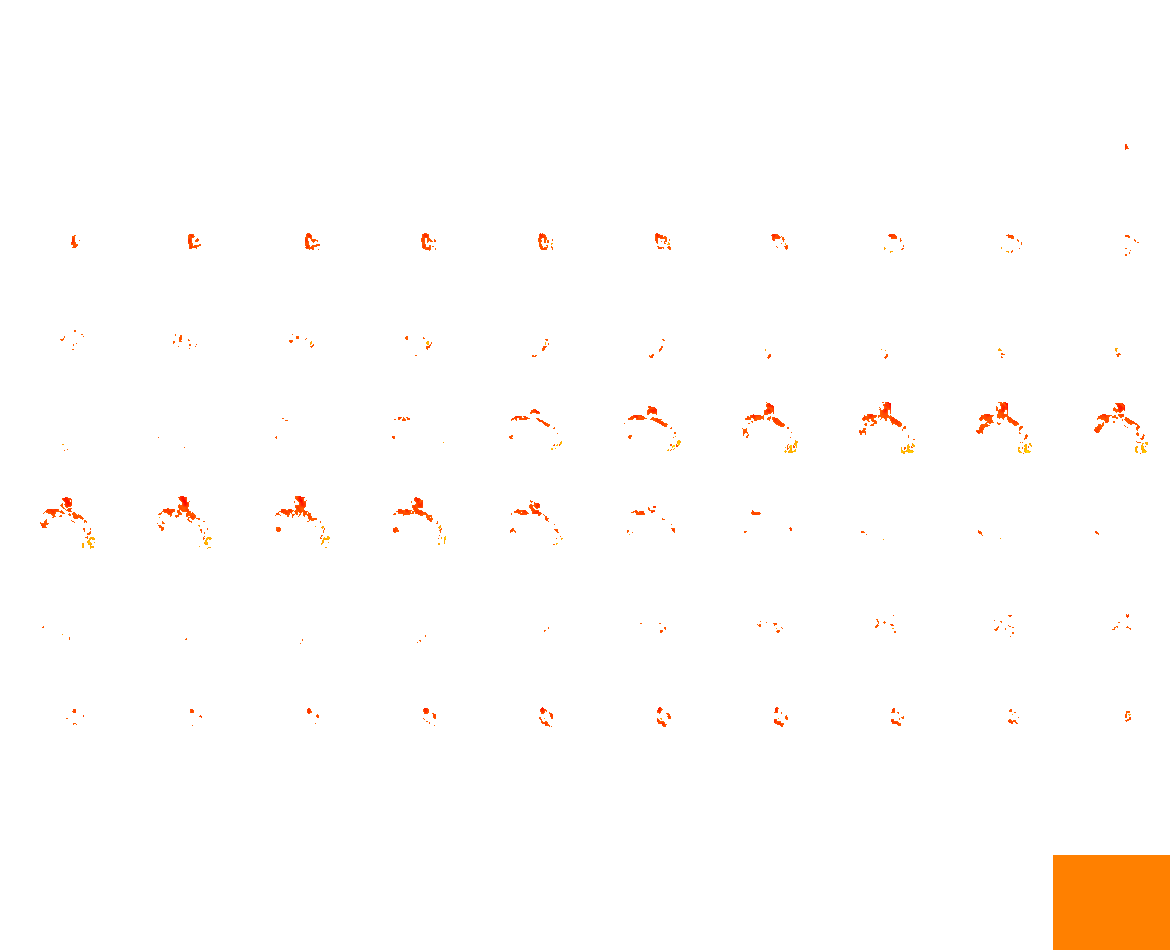

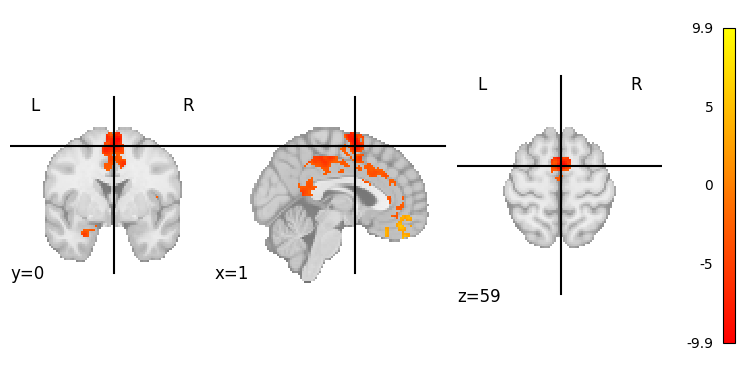

In [14]:
# contrast 0_100, 20-80 vs. the other (higher ambiguity)

c_vect = np.zeros(flm_dm.shape[1])
c_vect[[0, 1]] = 0.5 #0-100, 20-80
c_vect[[2, 3, 4]] = -0.5/3 # 40-60 45-55, 50-50

contrast = flm.compute_contrast(c_vect, stat_type="t", output_type="z_score")
# display = plotting.plot_stat_map(contrast, cmap="autumn")

contrast_thres, used_threshold = threshold_stats_img(contrast, height_control="fdr", alpha=0.05, mask_img=all_roi_masks)
print(used_threshold)
display = plotting.plot_stat_map(contrast_thres, cmap="autumn")

plotting.view_img(contrast_thres, cmap="autumn")

In [ ]:
# from nilearn.reporting import make_glm_report
# make_glm_report(flm, con_emo_vect)

# Others

In [ ]:
## WERID ACQUISITION TIME 

func.header.get_xyzt_units()
frame_times = json_data['time']['samples']['AcquisitionTime'][5:] #cut first 5 volumes 
frame_times = np.array(frame_times, dtype=float)
# frame_times = frame_times - frame_times[0] + t_r/2

frame_times[452]-frame_times[451]

import matplotlib.pyplot as plt
plt.plot(frame_times, "bo", markersize=0.5, linestyle="")

# ARCHIVED

##### ONSETS

In [ ]:
#onsets
import numpy as np
morph = []
emo = []
for i in np.arange(0, 11):
    if i<=4:
        morph.append(onsets_data['onsets'][0][i].squeeze())
    else:
        emo.append(onsets_data['onsets'][0][i][0][0])
      
#     print(onsets_data['onsets'][0][i].shape)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
for m in np.arange(0, 2):
    plt.plot(morph[m], np.ones(len(morph[m])), markersize=5, marker="o", linestyle="")
for e in emo:
    plt.axvline(e)

In [ ]:
# test if each condition contain 288 trials, each one second

emo=sorted(emo)
for i in np.arange(0, len(emo)):
    print(emo[i])
    
    if i < len(emo)-1:
        count = sum(emo[i] <= m < emo[i+1] for m_list in morph for m in m_list)
    else:
        count = sum( m >= emo[i] for m_list in morph for m in m_list)

    print(count)

##### Develope process for masks

In [ ]:

# Inferior Frontal Gyrus 
IFG_triangularis = image.index_img(ho_cort_prob_atlas_img, 4) # anterior - Inferior Frontal Gyrus, pars triangularis
IFG_opercularis = image.index_img(ho_cort_prob_atlas_img, 5) # posterior - Inferior Frontal Gyrus, pars opercularis
insula = image.index_img(ho_cort_prob_atlas_img, 1)

# threshold:
IFG_triangularis_thres = image.threshold_img(IFG_triangularis, 25)
IFG_opercularis_thres = image.threshold_img(IFG_opercularis, 25)
insula_thres = image.threshold_img(insula, 25)

# resample:

IFG_triangularis_resamp = image.resample_img(IFG_triangularis_thres, target_affine=func.affine, target_shape=func.shape[:3])
# print(IFG_triangularis_resamp.affine)
print(func.affine)
# display = plotting.plot_roi(IFG_triangularis_resamp, cmap="autumn", vmin=0)

IFG_opercularis_resamp = image.resample_img(IFG_opercularis_thres, target_affine=func.affine, target_shape=func.shape[:3])
# print(IFG_opercularis_resamp.affine)
# display = plotting.plot_roi(IFG_opercularis_resamp, cmap="autumn", vmin=0)

insula_resamp = image.resample_img(insula_thres, target_affine=func.affine, target_shape=func.shape[:3])
print(insula_resamp.affine)

# binarize + combine 
combined_IFG = image.math_img('np.logical_or.reduce([img1,img2,img3])',
                              img1=IFG_opercularis_resamp, 
                              img2=IFG_triangularis_resamp,
                              img3=insula_resamp)

display = plotting.plot_roi(combined_IFG, cmap='autumn', vmin=0)

In [ ]:
masked_func_2D = masking.apply_mask(func, all_roi_masks)
masked_func = masking.unmask(masked_func_2D, all_roi_masks)


# masked_func = masking.apply_mask(func, brain_mask)
# masked_func_4D = masking.unmask(masked_func, brain_mask)

plotting.view_img(image.index_img(masked_func, 100))

##### Changes of images after preprocessing looks unfamiliar - display mode y and z observe unfamiliar cut of image - observe better in anat img. #####

In [ ]:
# raw anat img

# plotting.view_img(anat, cmap="gray", vmax=400)
anat = image.load_img(f"/home/td/fMRI_internship/raw/{sub}/anat/{sub}_T1w.nii")
display = plotting.plot_anat(anat, display_mode='z', title="T1-weighted image", cut_coords=[-68, -48, -38, -24, -12, 54, 68])

# anat img after preprocessiong: "r" - realigned, "mr" - realigned + bias corrected, "wmr" - warped + bias corrected + realigned
anat = image.load_img(f"{base_path}/{sub}/{task}/r{sub}_T1w.nii")
display = plotting.plot_anat(anat, display_mode='z', title="T1-weighted image", cut_coords=[-68, -48, -38, -24, -12, 54, 68])

In [ ]:
# raw func image 
func = image.load_img(f"/home/td/fMRI_internship/raw/{sub}/func/{sub}_{task}_bold.nii.gz")
vol = 15
# plotting.view_img(image.index_img(func, vol))#, cmap="gray")
plotting.plot_img(image.index_img(func, vol), display_mode="z", cut_coords=[-68, -48, -38, -24, -12, 54, 68])

# preprocessed func images
# a - slice timing, r - realigned, w - warped, fwhm-4s - smooth
func = image.load_img(f"{base_path}/{sub}/{task}/fwhm-4swra{sub}_{task}_bold_roi.nii")
vol = 15
# plotting.view_img(image.index_img(func, vol))#, cmap="gray")
plotting.plot_img(image.index_img(func, vol), display_mode="z", cut_coords=[-68, -48, -38, -24, -12, 54, 68])

##### SKULL TRIPPING - no more needed, FirstLevelModel can compute brain mask internally


In [ ]:

from nilearn import masking
from nilearn import image

# PATH # 
workflow_name = 'spm_preproc1'
base_path = f"/home/td/fMRI_internship/derivatives/datasink/{workflow_name}"

subject_list = ['sub-01', 'sub-06']
task_list = ['task-emodet']

sub = subject_list[0]
task = task_list[0]

anat = image.load_img(f"{base_path}/{sub}/{task}/wmr{sub}_T1w.nii")
func = image.load_img(f"{base_path}/{sub}/{task}/fwhm-4swra{sub}_{task}_bold_roi.nii")


In [ ]:
brain_mask = masking.compute_brain_mask(anat, threshold=0.25)

masked_anat = masking.apply_mask(anat, brain_mask)
masked_anat_3D = masking.unmask(masked_anat, brain_mask)

masked_anat_3D.to_filename(f"/home/td/fMRI_internship/derivatives-ni-edu-env/{sub}/{task}/sk-wmr{sub}_T1w.nii")
plotting.view_img(masked_anat_3D, cmap="gray")

In [ ]:
masked_func = masking.apply_mask(func, brain_mask)
masked_func_4D = masking.unmask(masked_func, brain_mask)
masked_func_4D.to_filename(f"/home/td/fMRI_internship/derivatives-ni-edu-env/{sub}/{task}/sk-fwhm-4swra{sub}_{task}_bold_roi.nii")

plotting.view_img(image.index_img(masked_func_4D, 15))#, cmap="gray")

##### test affine if needed - can be used for other images in the same way


In [15]:
standard = image.load_img(f"/home/td/fMRI_internship/derivatives-ni-edu-env/{sub}/{task}/MNI152_T1_2mm_brain_resampled.nii.gz")
current_img = standard = image.load_img(f"/home/td/fMRI_internship/derivatives-ni-edu-env/{sub}/{task}/glm_af-ah-mol_fpr.nii")

print(standard.affine)
print(current_img.affine)